## Assignment 2, Natural Language Processing, Group 14

# Pre-processing

## Filter corpus

In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')
import re
import random
random.seed(45)

# Load and filter the data
news_df = pd.read_csv('us_equities_news_dataset.csv')
news_df = news_df.drop(columns=['article_id', 'url', 'category', 'release_date', 'provider'])
news_df = news_df.dropna(subset=['content'])
news_df['content'] = news_df['content'].astype(str)


# Filter for articles mentioning 'Nvidia' or 'NVDA' in the ticker, title, or content
pattern_nvidia = r'\b(?:Nvidia|NVDA)\b'
nvidia_mentioned_articles = news_df[
    (news_df['ticker'] == 'NVDA') | 
    news_df['title'].str.contains(pattern_nvidia, case=False, na=False) |
    news_df['content'].str.contains(pattern_nvidia, case=False, na=False)
]

# Save and reload filtered articles to avoid duplicate content
filtered_corpus = nvidia_mentioned_articles.copy()
filtered_corpus.to_csv('filtered_corpus.csv', index=False)

print('Filtered corpus dimensions:', filtered_corpus.shape)

Filtered corpus dimensions: (3459, 4)


## Clean and tokenize filtered corpus

In [2]:
news_df = pd.read_csv('filtered_corpus.csv')

# Set up stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess and tokenize text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove leading and trailing whitespace
    text = text.strip()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove 1-letter words and stopwords
    tokens = [token for token in tokens if len(token) > 1 and token not in stop_words]
    return tokens

# Apply the function to the content column and create a new 'tokens' column
news_df['tokens'] = news_df['content'].apply(preprocess_text)

# Remove duplicates based on the 'tokens' column
df = news_df.drop_duplicates(subset=['tokens'])
print('Filtered corpus dimensions:', df.shape)
print(df[['content', 'tokens']].head(10))


Filtered corpus dimensions: (3306, 5)
                                             content  \
0  ECB Effects\nThe move in the euro was huge  fa...   
1  6 Stocks To Watch  March 6 Trading Session\nSt...   
2  Investing com   A rout in Apple and Facebook  ...   
3  For Immediate ReleaseChicago  IL   January 13 ...   
4  With 4 500 companies bringing their innovation...   
5  With 4 500 companies bringing their innovation...   
6  When trading opened in 2019  investors were ju...   
7  Excitement is building up for the 2020 Summer ...   
8  For Immediate ReleaseChicago  IL   December 3 ...   
9  For Immediate ReleaseChicago  IL   November 26...   

                                              tokens  
0  [ecb, effects, move, euro, huge, falling, pips...  
1  [stocks, watch, march, trading, session, stock...  
2  [investing, com, rout, apple, facebook, nasdaq...  
3  [immediate, releasechicago, il, january, zacks...  
4  [companies, bringing, innovations, ces, jan, g...  
5  [companies, 

In [3]:
# Function to convert the tokenized column to a list of lists (flatten list)
def make_list_of_lists(data_frame, column_name):
    data = data_frame[column_name].tolist()
    return data

# Create the list of lists for modeling
data = make_list_of_lists(df, 'tokens')
print(len(data))

3306


## top-n% bottom-n% removal

In [4]:
from collections import Counter

def remove_n_percent(processed_text, n=0):
    if n > 0:
        # Flatten the list of lists to count word frequencies
        word_freq = Counter([word for doc in processed_text for word in doc])
        # Get the top n% most frequent words
        top_n = set([word for word, _ in word_freq.most_common(int(n/100*len(word_freq)))])
        # Get the bottom n% least frequent words
        bottom_n = set([word for word, _ in word_freq.most_common()[:-int(n/100*len(word_freq))-1:-1]])
        # Filter the data to remove these words
        processed_text = [[word for word in doc if word not in top_n and word not in bottom_n] for doc in processed_text]
        processed_text = [doc for doc in processed_text if len(doc) > 0]
    return processed_text

In [ ]:
# from collections import Counter
# 
# def remove_n_percent(data, n=0):
#     """
#     Removes the top n% and bottom n% of the most and least frequent words from the input list of lists.
#     
#     Parameters:
#     data (list of lists): The input data, where each sublist contains tokenized text.
#     n (float): The percentage of the most and least common words to remove.
#     
#     Returns:
#     list of lists: The input data with the top n% and bottom n% words removed.
#     """
#     if n <= 0 or n > 50:
#         raise ValueError("n should be greater than 0 and less than or equal to 50.")
#     
#     # Flatten the list of lists to count word frequencies
#     all_words = [word for sublist in data for word in sublist]
#     word_freq = Counter(all_words)
#     # Calculate the number of words to remove for top and bottom n%
#     num_words_to_remove = int(n / 100 * len(word_freq))
#     # Get the top n% most frequent words
#     top_n_words = {word for word, _ in word_freq.most_common(num_words_to_remove)}   
#     # Get the bottom n% least frequent words
#     bottom_n_words = {word for word, _ in word_freq.most_common()[:-num_words_to_remove -1:-1]}    
#     # Combine top and bottom n% words to be removed
#     words_to_remove = top_n_words.union(bottom_n_words)   
#     # Filter the data to remove these words
#     filtered_data = [[word for word in sublist if word not in words_to_remove] for sublist in data]  
#     filtered_data = [doc for doc in filtered_data if len(doc) > 0]
#     
#     return filtered_data

# Train FLSA-W Model

# Experimentation

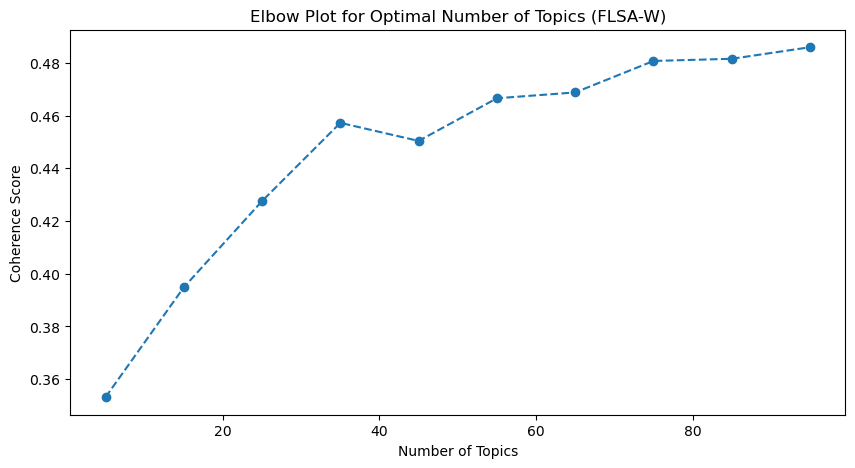

In [5]:
import matplotlib.pyplot as plt
from FuzzyTM import FLSA_W
# Range of topic numbers to test
topic_numbers = range(5, 101, 10)
coherence_scores = []

for num_topics in topic_numbers:
    flsaW = FLSA_W(
        input_file=data,  # Preprocessed data
        num_topics=num_topics,
        num_words=20
    )
    pwgt, ptgd = flsaW.get_matrices()  # Train the model
    coherence_score = flsaW.get_coherence_score()  # Calculate coherence
    coherence_scores.append(coherence_score)

# Plotting the Elbow Plot
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, coherence_scores, marker='o', linestyle='--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics (FLSA-W)')
plt.show()

After 30 topics it the curve starts to flatten. There is no substantial increase in the coherence score. We can experiment with 35 topics.

# Iteration 0: full data

In [7]:
# Parameters
flsaw_data = data
num_topics = 35
num_words = 20

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0031*"inning" + 0.003*"mgt" + 0.003*"resisted" + 0.0029*"pitt" + 0.0028*"wilson" + 0.0028*"mistrust" + 0.0026*"proficiency" + 0.0025*"misunderstood" + 0.0025*"helix" + 0.0024*"qplum" + 0.0024*"exuberant" + 0.0023*"dissect" + 0.0023*"christian" + 0.0021*"copeland" + 0.0021*"invisible" + 0.0021*"gatherings" + 0.002*"alberta" + 0.002*"crystallize" + 0.0019*"distinguished" + 0.0019*"oversimplifying"'), (1, '0.0012*"reiterates" + 0.001*"dives" + 0.001*"hans" + 0.001*"mott" + 0.001*"functioning" + 0.001*"mnk" + 0.0009*"extr" + 0.0009*"nwsa" + 0.0009*"ctrl" + 0.0009*"slim" + 0.0009*"satisfy" + 0.0009*"allison" + 0.0009*"rankintel" + 0.0009*"spared" + 0.0008*"nrg" + 0.0008*"htz" + 0.0008*"evaluates" + 0.0008*"kw" + 0.0008*"cliff" + 0.0008*"pinning"'), (2, '0.015*"unpredictable" + 0.0146*"thomas" + 0.0122*"newspaper" + 0.0119*"discussing" + 0.0118*"centered" + 0.0106*"afford" + 0.0104*"controversy" + 0.0086*"entrepreneurs" + 0.0081*"woman" + 0.0072*"passage" + 0.006*"daniel" + 0.006*"em

Diversity score is almost 1.0 indicates that the topics are completely distinct from each other, with no significant overlap in the words that define them. 

Coherence score of 0.47 suggests that while the topics have some level of meaningful structure, there is room for improvement.

Content: Some of the very frequent words like nvda and nvidia are in different topics. We might use lemmatization and remove some of the most frequent words.

# Lemmatization

In [11]:
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already installed
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply the lemmatizer to the tokenized 'tokens' column using .loc[]
df.loc[:, 'lemmatized_tokens'] = df['tokens'].apply(lemmatize_text)

# Create the list of lists for modeling
data_lem = make_list_of_lists(df, 'lemmatized_tokens')


# Iteration 1: Remove 5% most common and rarest words

In [12]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 5)
num_topics=35
num_words=20

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0136*"owned" + 0.0134*"founder" + 0.0132*"agreed" + 0.0127*"allows" + 0.012*"site" + 0.0118*"shopping" + 0.0108*"welcome" + 0.0108*"fine" + 0.0107*"location" + 0.0107*"allow" + 0.0107*"k" + 0.0104*"class" + 0.0104*"final" + 0.0104*"study" + 0.01*"typically" + 0.0096*"battle" + 0.0089*"youtube" + 0.0089*"argument" + 0.0088*"music" + 0.0088*"facilitate"'), (1, '0.0065*"produced" + 0.0062*"releasechicago" + 0.0062*"discussed" + 0.0056*"affiliate" + 0.0054*"mother" + 0.0052*"contactzacks" + 0.005*"enabling" + 0.005*"lon" + 0.0049*"sensitive" + 0.0045*"saving" + 0.0044*"struggling" + 0.0043*"slower" + 0.0043*"charging" + 0.0043*"gartner" + 0.0042*"station" + 0.0041*"resulting" + 0.0041*"monetary" + 0.0041*"operational" + 0.0039*"agency" + 0.0039*"fortune"'), (2, '0.0022*"troy" + 0.0019*"premarket" + 0.0015*"conclusively" + 0.0013*"qrvo" + 0.0013*"kemet" + 0.0013*"kem" + 0.0012*"randewich" + 0.0012*"noel" + 0.0012*"delve" + 0.0011*"smh" + 0.0011*"soxx" + 0.0011*"polled" + 0.001*"syno

Coherence score dropped while diversity seems almost stable.

# Iteration 2: Remove 10%

In [15]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 10)
num_topics=35
num_words=20

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0278*"capex" + 0.0182*"shut" + 0.0178*"timeline" + 0.0176*"moat" + 0.0167*"kansa" + 0.0167*"choosing" + 0.0167*"wrap" + 0.0166*"hanging" + 0.0166*"procedure" + 0.0162*"down" + 0.0161*"hopefully" + 0.0161*"adjusting" + 0.016*"collaborative" + 0.0156*"broadband" + 0.0154*"commissioner" + 0.0143*"nowhere" + 0.0139*"folk" + 0.0133*"fought" + 0.0133*"accumulate" + 0.0131*"symbol"'), (1, '0.0516*"modern" + 0.045*"radical" + 0.0396*"teacher" + 0.037*"chaos" + 0.0275*"titled" + 0.0275*"socially" + 0.0261*"religion" + 0.0246*"sean" + 0.0235*"eternal" + 0.0234*"yep" + 0.0228*"reissued" + 0.0222*"revolutionized" + 0.0222*"kevinbcook" + 0.022*"tinker" + 0.022*"destined" + 0.0219*"religious" + 0.0208*"founding" + 0.0206*"philosophy" + 0.0197*"adult" + 0.0194*"curiosity"'), (2, '0.0384*"surgical" + 0.0373*"walking" + 0.0343*"legalized" + 0.034*"illustrated" + 0.0322*"lifestyle" + 0.031*"supreme" + 0.031*"hey" + 0.0303*"monopoly" + 0.0301*"scheme" + 0.0286*"legalize" + 0.0279*"appropriately" 

A significant increase in Coherence and Diversity score after the first iteration but still lower than Iteration 0.

## Iteration 3: Remove 15%

In [16]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 15)
num_topics=35
num_words=20

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0036*"cleaning" + 0.0033*"tapping" + 0.0032*"drawn" + 0.0032*"actionable" + 0.0031*"intact" + 0.003*"temperature" + 0.003*"processed" + 0.003*"seamless" + 0.0029*"casual" + 0.0029*"workplace" + 0.0028*"ticket" + 0.0028*"elect" + 0.0028*"length" + 0.0028*"unusual" + 0.0027*"gild" + 0.0027*"roller" + 0.0027*"smb" + 0.0026*"odd" + 0.0026*"jon" + 0.0026*"itunes"'), (1, '0.021*"hyundai" + 0.0184*"suggestion" + 0.017*"expression" + 0.0164*"comply" + 0.0147*"somebody" + 0.0127*"promotion" + 0.0122*"hertz" + 0.0114*"modi" + 0.0114*"hynix" + 0.0108*"ubereats" + 0.0106*"leak" + 0.0101*"tweaking" + 0.0099*"shantanu" + 0.0099*"narayen" + 0.0098*"walker" + 0.0093*"murder" + 0.0092*"employed" + 0.0088*"sirius" + 0.0088*"resultant" + 0.0079*"jean"'), (2, '0.0127*"epiphany" + 0.0123*"huxley" + 0.0117*"darwin" + 0.0114*"julian" + 0.0111*"explanatory" + 0.0111*"silt" + 0.0111*"nigel" + 0.0111*"stale" + 0.0111*"bertrand" + 0.0111*"kwa" + 0.0111*"humanism" + 0.0111*"moccasin" + 0.0111*"pointless" 

Coherence score of approximately 0.49 is an improvement from the starting point 0.45. This suggests that the topics generated in this iteration are more semantically meaningful, with words in each topic being more closely related. The increase in coherence indicates that the adjusting top_n_percent to 15% helped create more coherent and contextually relevant topics.

## Iteration 4: num_words per topic = 10

In [19]:
# Parameters

flsaw_data = remove_n_percent(data_lem, 15)
num_topics=35
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0167*"concerning" + 0.0154*"appreciate" + 0.013*"approve" + 0.0122*"precise" + 0.0117*"diamond" + 0.0101*"sophisticated" + 0.0085*"cooperation" + 0.007*"consequence" + 0.0066*"understood" + 0.0065*"programmed"'), (1, '0.0247*"epidemic" + 0.021*"respiratory" + 0.0208*"rader" + 0.0205*"spanish" + 0.0203*"vaccine" + 0.0179*"mortality" + 0.0179*"mers" + 0.0179*"influenza" + 0.0179*"caltech" + 0.0179*"fooling"'), (2, '0.0046*"checking" + 0.0045*"confirming" + 0.004*"reasonably" + 0.0039*"pack" + 0.0039*"dead" + 0.0038*"tonight" + 0.0036*"referred" + 0.0036*"agent" + 0.0034*"gop" + 0.0033*"convincing"'), (3, '0.0018*"lastly" + 0.0018*"normalize" + 0.0018*"allied" + 0.0018*"stringent" + 0.0018*"enthusiasm" + 0.0018*"dominating" + 0.0017*"likelihood" + 0.0016*"stalled" + 0.0016*"consolidating" + 0.0016*"retires"'), (4, '0.0008*"aftermarket" + 0.0008*"detailsnon" + 0.0007*"cy" + 0.0007*"pickscurrently" + 0.0007*"segmental" + 0.0007*"colette" + 0.0007*"differentiated" + 0.0007*"alv" + 0.

Coherence score decreased when lowering number of words per topic. Let's slightly increase it.

## Iteration 5: num_words per topic = 15

In [20]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 15)
num_topics=35
num_words=15

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0272*"afford" + 0.0239*"dig" + 0.0235*"ipads" + 0.0231*"bag" + 0.0222*"hero" + 0.022*"practical" + 0.022*"unpredictable" + 0.0212*"centered" + 0.0207*"perfectly" + 0.0207*"thomas" + 0.0199*"realm" + 0.0186*"infinite" + 0.0186*"broadening" + 0.0184*"knowing" + 0.0183*"newspaper"'), (1, '0.0149*"fantastic" + 0.0125*"simplify" + 0.0121*"incredibly" + 0.0112*"tail" + 0.011*"economically" + 0.0105*"genetics" + 0.0103*"opted" + 0.0102*"identifies" + 0.0099*"root" + 0.0092*"lump" + 0.0091*"unparalleled" + 0.0089*"bio" + 0.0088*"borrowed" + 0.0086*"dilemma" + 0.0086*"variation"'), (2, '0.0445*"preserve" + 0.0396*"deeply" + 0.0309*"downstream" + 0.0298*"jungle" + 0.0283*"treasure" + 0.0262*"paced" + 0.0252*"euphoric" + 0.025*"enduring" + 0.0242*"died" + 0.024*"pollution" + 0.0236*"summed" + 0.0231*"explored" + 0.0226*"crsp" + 0.0222*"judgment" + 0.022*"psychologically"'), (3, '0.0141*"supreme" + 0.0139*"promotion" + 0.0123*"comply" + 0.0117*"disorder" + 0.0109*"resultant" + 0.0106*"obse

Coherence score slightly increased but still lower than the default value=20.

## Iteration 6: num_words per topic = 25

In [25]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 15)
num_topics=35
num_words=25

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0116*"judgement" + 0.0105*"neurochemistry" + 0.0105*"everythingfor" + 0.0105*"anarchist" + 0.0105*"visceral" + 0.0105*"bakunin" + 0.0105*"brockman" + 0.0105*"laughed" + 0.0105*"neurotransmitter" + 0.0105*"multiplicity" + 0.0105*"anemia" + 0.0105*"adaline" + 0.0105*"bloodstream" + 0.0105*"misunderstand" + 0.0105*"homepage" + 0.0105*"stimulation" + 0.0105*"ecosphere" + 0.0105*"heritable" + 0.0105*"foretaste" + 0.0105*"neuro" + 0.0105*"peaceable" + 0.0105*"emily" + 0.0105*"pleasant" + 0.0105*"philosopher" + 0.0105*"anarchism"'), (1, '0.0008*"aftermarket" + 0.0008*"detailsnon" + 0.0007*"cy" + 0.0007*"pickscurrently" + 0.0007*"segmental" + 0.0007*"colette" + 0.0007*"alv" + 0.0007*"differentiated" + 0.0007*"splendid" + 0.0006*"friedrichshafen" + 0.0006*"kramer" + 0.0006*"detailsrevenues" + 0.0006*"amounted" + 0.0006*"sabotaging" + 0.0006*"cmos" + 0.0006*"enhances" + 0.0006*"shortlist" + 0.0006*"prototyping" + 0.0005*"hcm" + 0.0005*"underperformance" + 0.0005*"turbulent" + 0.0005*"skx

Increasing the number of words per topic above 20 almost did not change the metrics. The lower the number the easier to interpret qualitatively.

# TF-IDF base filtering

Removing the top and bottom 15% of the most frequent words seems to have improved coherence without significantly affecting diversity. This suggests that the common and rare words removed in this step were likely not contributing much to topic quality. However, by relying solely on raw frequency, we may have removed important words from the corpus. To address this, we can use a document frequency threshold as part of the TF-IDF calculation, removing words based on the proportion of documents they appear in rather than just their raw frequency. This approach takes into account how widely or narrowly distributed a word is across the corpus.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the lemmatized tokens back to text format for TF-IDF processing
df.loc[:, 'lemmatized_text'] = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.75)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_text'])

# Get the feature names (words) that meet the TF-IDF thresholds
tfidf_vocab = set(tfidf_vectorizer.get_feature_names_out())

# Get all unique words in the original lemmatized tokens
original_vocab = set(word for doc in df['lemmatized_tokens'] for word in doc)

# Identify words that were removed
removed_words = original_vocab - tfidf_vocab

# Inspect the removed words

print("Number of words removed by TF-IDF filtering:")
print(len(removed_words))
print("Sample words removed by TF-IDF filtering:")
print(list(removed_words)[:20])

# Filter out words not meeting the TF-IDF criteria
def tfidf_filter(text):
    return [word for word in text if word in tfidf_vocab]

df_filtered = df.copy()
# Apply the TF-IDF filtering to the lemmatized tokens
df_filtered.loc[:, 'filtered_tokens'] = df['lemmatized_tokens'].apply(tfidf_filter)

# Convert the final filtered tokens to a list of lists for topic modeling
data_tf = make_list_of_lists(df, 'filtered_tokens')
data_tf = [doc for doc in data_tf if len(doc) > 0]

Number of words removed by TF-IDF filtering:
28174
Sample words removed by TF-IDF filtering:
['hosting', 'maddock', 'beneflex', 'bonanza', 'sssg', 'undermined', 'arcbest', 'cpi', 'hcp', 'ralliessemiconductor', 'segmentthe', 'supercenters', 'catalystexpanding', 'disturbing', 'catalystsnvidia', 'disappoints', 'array', 'waldman', 'reformulated', 'shrunk']


We can see it removed typos

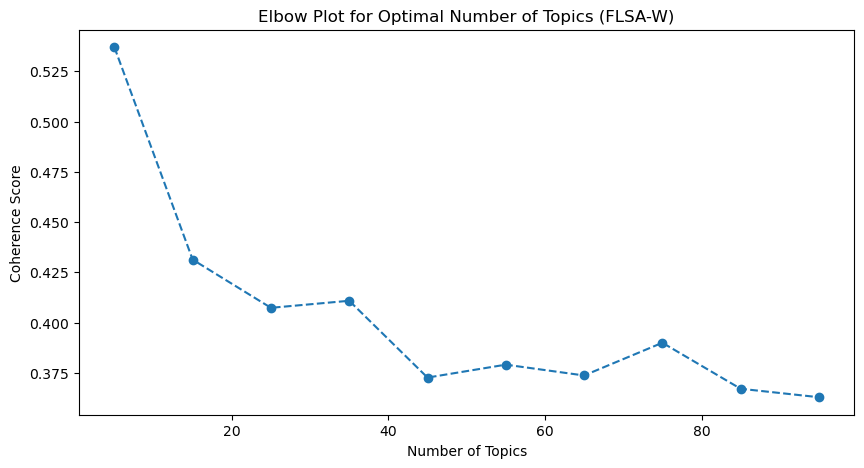

In [37]:
# Parameters
topic_numbers = range(5, 101, 10)
coherence_scores = []

for num_topics in topic_numbers:
    flsaW = FLSA_W(
        input_file=data_tf,  # Preprocessed data
        num_topics=num_topics,
        num_words=20
    )
    pwgt, ptgd = flsaW.get_matrices()  # Train the model
    coherence_score = flsaW.get_coherence_score()  # Calculate coherence
    coherence_scores.append(coherence_score)

# Plotting the Elbow Plot
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, coherence_scores, marker='o', linestyle='--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics (FLSA-W)')
plt.show()

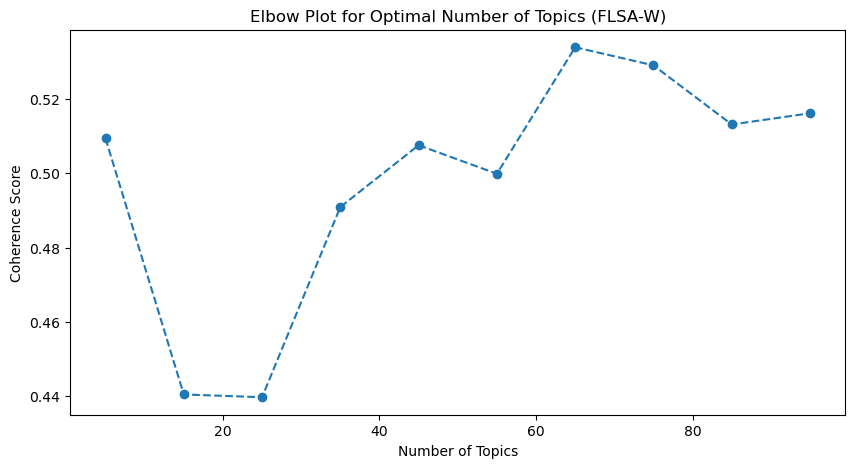

In [38]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 15)
topic_numbers = range(5, 101, 10)
coherence_scores = []

for num_topics in topic_numbers:
    flsaW = FLSA_W(
        input_file=flsaw_data,  # Preprocessed data
        num_topics=num_topics,
        num_words=20
    )
    pwgt, ptgd = flsaW.get_matrices()  # Train the model
    coherence_score = flsaW.get_coherence_score()  # Calculate coherence
    coherence_scores.append(coherence_score)

# Plotting the Elbow Plot
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, coherence_scores, marker='o', linestyle='--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics (FLSA-W)')
plt.show()

In [39]:
# Parameters
flsaw_data = data_tf
num_topics=5
num_words=20

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0315*"investment" + 0.0255*"recommendation" + 0.0244*"research" + 0.0228*"immediate" + 0.0222*"notice" + 0.022*"opinion" + 0.0219*"accounting" + 0.0217*"subject" + 0.0215*"suitable" + 0.0215*"security" + 0.0214*"described" + 0.0213*"expressed" + 0.0209*"provided" + 0.0207*"visit" + 0.0205*"identified" + 0.0199*"advice" + 0.0195*"displayed" + 0.0193*"inherent" + 0.0185*"assumed" + 0.0183*"constitutes"'), (1, '0.0198*"hold" + 0.0191*"rank" + 0.0185*"buy" + 0.0169*"estimate" + 0.0166*"potential" + 0.0161*"management" + 0.0155*"sell" + 0.0152*"performance" + 0.015*"portfolio" + 0.015*"current" + 0.015*"release" + 0.0146*"given" + 0.0144*"industry" + 0.0144*"past" + 0.0142*"without" + 0.0134*"whether" + 0.0132*"medium" + 0.0131*"date" + 0.0127*"making" + 0.0127*"material"'), (2, '0.0033*"intc" + 0.003*"gained" + 0.0029*"read" + 0.0028*"provide" + 0.0027*"investing" + 0.0027*"msft" + 0.0027*"googl" + 0.0027*"state" + 0.0027*"following" + 0.0026*"maker" + 0.0026*"micro" + 0.0026*"note

In [40]:
# Parameters
flsaw_data = remove_n_percent(data_lem, 15)
num_topics=5
num_words=20

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0096*"infected" + 0.0093*"syndrome" + 0.0093*"spanish" + 0.0093*"originated" + 0.0091*"sars" + 0.0084*"inovio" + 0.0084*"epidemic" + 0.0082*"symptom" + 0.0078*"joking" + 0.0076*"isolated" + 0.0075*"plague" + 0.0073*"geometric" + 0.0073*"breathing" + 0.0072*"ncov" + 0.0071*"chess" + 0.0071*"disproportionately" + 0.007*"portuguese" + 0.007*"silk" + 0.007*"mathematician" + 0.007*"jane"'), (1, '0.0007*"frequent" + 0.0006*"accept" + 0.0006*"grows" + 0.0006*"activist" + 0.0006*"wrap" + 0.0006*"geographic" + 0.0006*"charged" + 0.0006*"preference" + 0.0006*"kingdom" + 0.0006*"magazine" + 0.0006*"wondering" + 0.0006*"favoring" + 0.0006*"ihs" + 0.0006*"ally" + 0.0006*"checking" + 0.0006*"incorporate" + 0.0006*"confirming" + 0.0006*"statista" + 0.0006*"referred" + 0.0006*"latin"'), (2, '0.0115*"professor" + 0.0098*"synthesis" + 0.0092*"creativity" + 0.0084*"chaos" + 0.0082*"unstoppable" + 0.008*"woke" + 0.0077*"illusion" + 0.0073*"reconciliation" + 0.0071*"founding" + 0.0071*"pretend" + 0

## Train LDA model

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models import CoherenceModel
# import re
# 
# read_processed_data = df['tokens']
# # Create a dictionary and corpus from the preprocessed data
# dictionary = corpora.Dictionary(read_processed_data)
# corpus = [dictionary.doc2bow(text) for text in read_processed_data]
# 
# # Train the LDA model
# lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15, random_state=100, passes=10)
# 
# # Print the topics found by the LDA model
# topics = lda_model.print_topics(num_words=5)
# for topic in topics:
#     print(topic)
# #Get coherence score
# print(CoherenceModel(model=lda_model, texts=read_processed_data, dictionary=dictionary, coherence='c_v').get_coherence())

In [ ]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import re

# Create a dictionary and corpus from the preprocessed data
dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

# Train the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, random_state=100, passes=10)

# Print the topics found by the LDA model
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)
#Get coherence score
print(CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v').get_coherence())

##  BERTTopic

In [ ]:
import pandas as pd
from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer
import nltk
nltk.download("stopwords")
nltk.download('punkt_tab')

In [ ]:
## Bert Topic code
# Convert the 'preprocessed_content' column to a list of documents (text format)
documents = [" ".join(tokens) for tokens in df['preprocessed_content']]

# Initialize BERTopic model
topic_model = BERTopic()

# Fit the model on the documents to get topics and probabilities
topics, probabilities = topic_model.fit_transform(documents)

# Show a summary of topics
print(topic_model.get_topic_info())


In [ ]:
#check certain topic
num_topic = 0
topic_model.get_topic(num_topic)

In [ ]:
#Heatmap
topic_model.visualize_heatmap(width=1000, height=1000)